### Altum AG

Folowed the instructions here

https://github.com/rsinghlab/AltumAge 


In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from scipy.stats import linregress


In [2]:
# Load Altum Age cpgs
cpgs = np.array(pd.read_pickle("AltumAge/multi_platform_cpgs.pkl"))
# Load model 
scaler = pd.read_pickle('AltumAge/scaler.pkl')
AltumAge = tf.keras.models.load_model('AltumAge/AltumAge.h5')

In [3]:
def split_in_train_test(meth, age_data, test_set):
    """Split the dataset into train and test"""
    #Metadata
    metadata_test = age_data.loc[age_data["tissue_sample_id"].isin(test_set["sample_id"])]
    metadata_train = age_data.loc[~age_data["tissue_sample_id"].isin(test_set["sample_id"])]
    #Age data
    y_test = list(metadata_test["AGE"])
    y_train = list(metadata_train["AGE"])
    #Methylation data
    X_train = meth.loc[metadata_train.Sample_ID]
    X_test = meth.loc[metadata_test.Sample_ID]

    return(X_train, X_test, y_train, y_test)


def compute_metrics(y_test, y_test_pred):
    metrics = {}
    metrics["r2"] = r2_score(y_test, y_test_pred)
    metrics["rmse"] = mean_squared_error(y_test, y_test_pred, squared=False)
    metrics["mae"] = mean_absolute_error(y_test, y_test_pred)
    metrics["med"] = median_absolute_error(y_test, y_test_pred)
    lr = linregress(y_test, y_test_pred)
    metrics["slope"] = lr.slope
    metrics["intercept"] = lr.intercept
    metrics["cor"] = lr.rvalue
    return metrics

def plot_model_fit(y_test, y_test_pred,
                data_modality="DNA Methylation", 
                data_set="Validation",
                smoker_status=None, 
                color="#55812C",
                title_override=None,
                fig_output_path="scatterplot_methylation.pdf"):
        
    metrics = compute_metrics(y_test, y_test_pred)

    # kind="reg" is not supported when using hue;
    # as a workaround we plot scatter separately.
    if smoker_status is not None:
        scatter = False
    else:
        scatter = True

    jointgrid = sns.jointplot(x=y_test, y=y_test_pred,
                                kind="reg",
                                truncate=False,
                                scatter=scatter,
                                fit_reg=True,
                                color=color,
                                xlim=(20, 70),
                                ylim=(20, 70))
    
    jointgrid.ax_joint.axline([0, 0], [1, 1], transform=jointgrid.ax_joint.transAxes,
                                linestyle="--", alpha=0.8, color='darkgray')

    if smoker_status is not None:
        sns.scatterplot(x=y_test, y=y_test_pred, hue=smoker_status, ax=jointgrid.ax_joint)
        sns.move_legend(jointgrid.ax_joint, "lower right")

    if title_override:
        plt.title(title_override)
    else:
        plt.title(f"LighGBM Model Fit for {data_modality} - {data_set} (N = {len(y_test)})")
    jointgrid.ax_joint.set_ylabel("Predicted Values")
    jointgrid.ax_joint.set_xlabel("True Value")
    t = plt.text(.05, .7,
                    'r²={:.3f}\nrmse={:.3f}\nmae={:.3f}\nmed={:.3f}\nslope={:.3f}\nintercept={:.3f}\ncor={:.3f}'.format(
                        metrics["r2"], metrics["rmse"], metrics["mae"], metrics["med"], metrics["slope"],
                        metrics["intercept"], metrics["cor"]),
                    transform=jointgrid.ax_joint.transAxes)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor=color))
    jointgrid.fig.subplots_adjust(top=0.95)
    plt.tight_layout()
    if fig_output_path:
        plt.savefig(fig_output_path, format="pdf", bbox_inches="tight")

## Lung  

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


1/2 [==============>...............] - ETA: 0s

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


2/2 [==============================] - 0s 0s/step


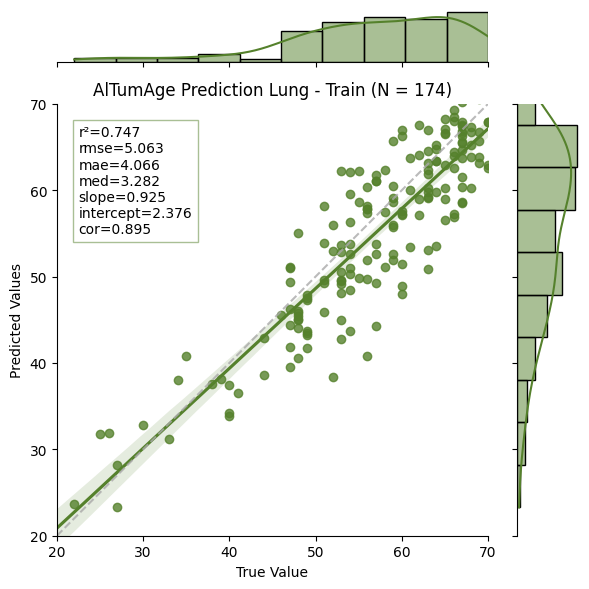

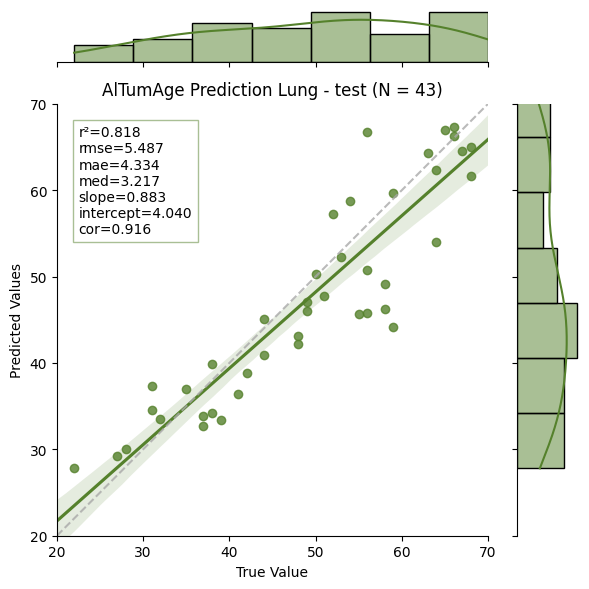

In [8]:
lung_meth_data = pd.read_csv("../../results/2.epigenetic_clocks/AltumAge/lung_BQMI_normalized.csv", index_col=0)
lung_test_data = pd.read_csv("../../metadata/lung_test_metadata.csv")
lung_age_data = pd.read_csv("../../metadata/lung_annotation_meth.csv")

# Reoder 
lung_meth_data = lung_meth_data[cpgs]

# Split in train and test
X_train, X_test, y_train, y_test = split_in_train_test(lung_meth_data, lung_age_data, lung_test_data)

### Predict on train 
X_train_scaled = scaler.transform(X_train)
pred_age_train_lung = AltumAge.predict(X_train_scaled).flatten()

metrics_train_lung = compute_metrics(y_train, pred_age_train_lung)
metrics_train_lung["set"] = "Train"
metrics_train_lung["tissue"] = "Lung"

plot_model_fit(y_train, 
        pred_age_train_lung, 
        data_set="Train", 
        title_override = f"AlTumAge Prediction Lung - Train (N = {X_train.shape[0]})", 
        fig_output_path="../../aging_notes/figures/2.epigenetic_clocks/3.AltumAge_lung_train.pdf")

### Predict on test
X_test_scaled = scaler.transform(X_test)
pred_age_test_lung = AltumAge.predict(X_test_scaled).flatten()

metrics_test_lung = compute_metrics(y_test, pred_age_test_lung)
metrics_test_lung["set"] = "test"
metrics_test_lung["tissue"] = "Lung"

plot_model_fit(y_test, 
        pred_age_test_lung, 
        data_set="test", 
        title_override = f"AlTumAge Prediction Lung - test (N = {X_test.shape[0]})", 
        fig_output_path="../../aging_notes/figures/2.epigenetic_clocks/3.AltumAge_lung_test.pdf")

train_df = pd.DataFrame({"pred": pred_age_train_lung, "true": y_train, "sample": X_train.index })
train_df.to_csv("../../results/2.epigenetic_clocks/AltumAge/AltumLung_train.csv")

test_df = pd.DataFrame({"pred": pred_age_test_lung, "true": y_test, "sample": X_test.index })
test_df.to_csv("../../results/2.epigenetic_clocks/AltumAge/AltumLung_test.csv")


### Colon Transverse

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


6/6 [==============================] - 0s 61ms/step


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


2/2 [==============================] - 0s 8ms/step


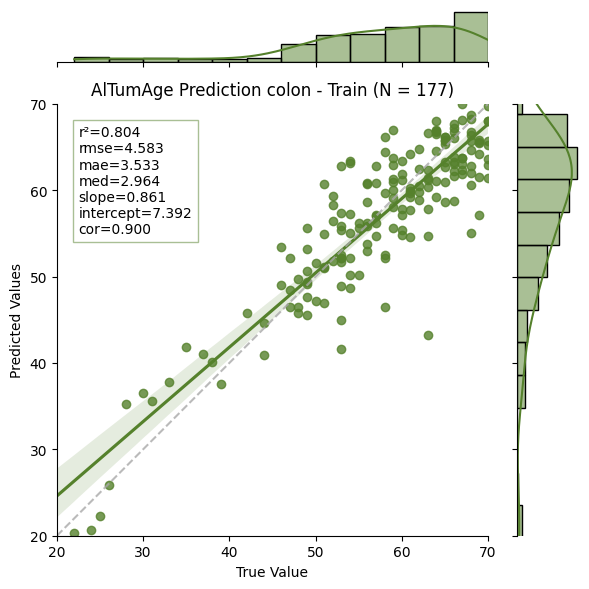

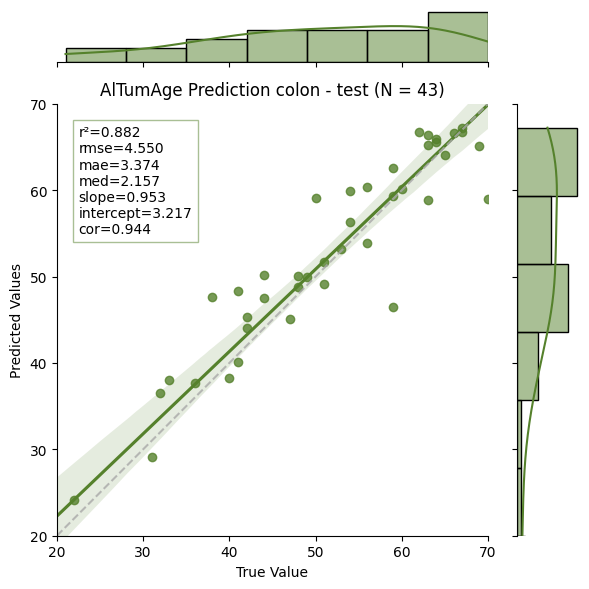

In [10]:
colon_meth_data = pd.read_csv("../../results/2.epigenetic_clocks/AltumAge/colon_BQMI_normalized.csv", index_col=0)
colon_test_data = pd.read_csv("../../metadata/colon_test_metadata.csv")
colon_age_data = pd.read_csv("../../metadata/colon_annotation_meth.csv")

# Reoder 
colon_meth_data = colon_meth_data[cpgs]

# Split in train and test
X_train, X_test, y_train, y_test = split_in_train_test(colon_meth_data, colon_age_data, colon_test_data)

### Predict on train 
X_train_scaled = scaler.transform(X_train)
pred_age_train_colon = AltumAge.predict(X_train_scaled).flatten()

metrics_train_colon = compute_metrics(y_train, pred_age_train_colon)
metrics_train_colon["set"] = "Train"
metrics_train_colon["tissue"] = "Colon"

plot_model_fit(y_train, 
        pred_age_train_colon, 
        data_set="Train", 
        title_override = f"AlTumAge Prediction colon - Train (N = {X_train.shape[0]})", 
        fig_output_path="../../aging_notes/figures/2.epigenetic_clocks/3.AltumAge_colon_train.pdf")

### Predict on test
X_test_scaled = scaler.transform(X_test)
pred_age_test_colon = AltumAge.predict(X_test_scaled).flatten()

metrics_test_colon = compute_metrics(y_test, pred_age_test_colon)
metrics_test_colon["set"] = "test"
metrics_test_colon["tissue"] = "Colon"

plot_model_fit(y_test, 
        pred_age_test_colon, 
        data_set="test", 
        title_override = f"AlTumAge Prediction colon - test (N = {X_test.shape[0]})", 
        fig_output_path="../../aging_notes/figures/2.epigenetic_clocks/3.AltumAge_colon_test.pdf")


train_df = pd.DataFrame({"pred": pred_age_train_colon, "true": y_train, "sample": X_train.index })
train_df.to_csv("../../results/2.epigenetic_clocks/AltumAge/AltumColon_train.csv")

test_df = pd.DataFrame({"pred": pred_age_test_colon, "true": y_test, "sample": X_test.index })
test_df.to_csv("../../results/2.epigenetic_clocks/AltumAge/AltumColon_test.csv")


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 0s 3ms/step


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


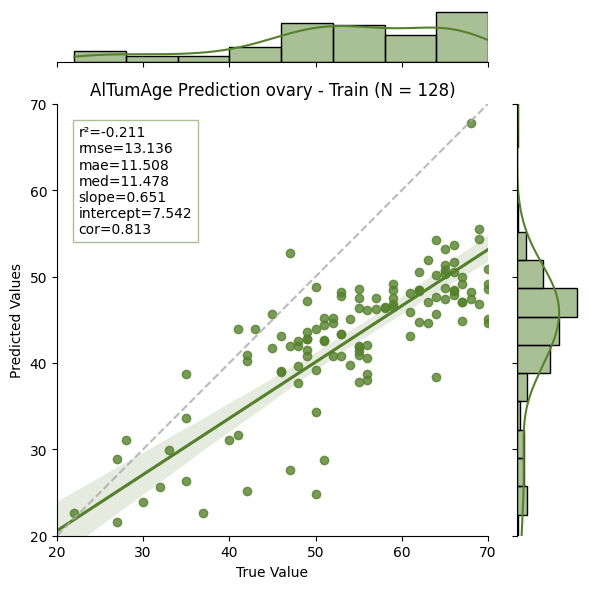

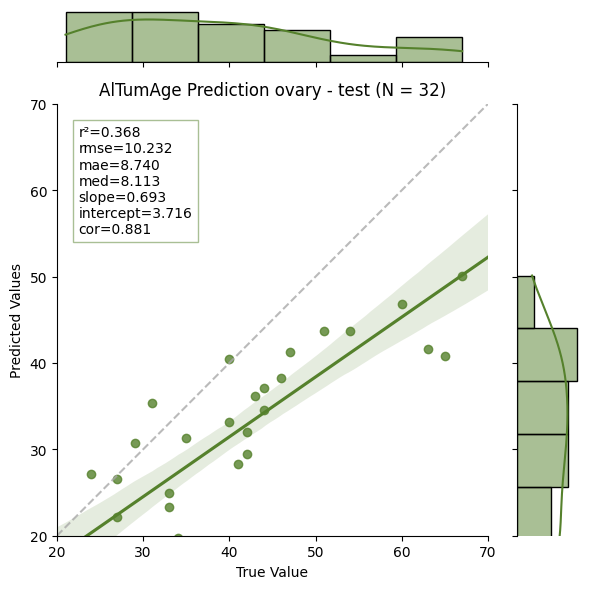

In [11]:
ovary_meth_data = pd.read_csv("../../results/2.epigenetic_clocks/AltumAge/ovary_BQMI_normalized.csv", index_col=0)
ovary_test_data = pd.read_csv("../../metadata/ovary_test_metadata.csv")
ovary_age_data = pd.read_csv("../../metadata/ovary_annotation_meth.csv")

# Reoder 
ovary_meth_data = ovary_meth_data[cpgs]

# Split in train and test
X_train, X_test, y_train, y_test = split_in_train_test(ovary_meth_data, ovary_age_data, ovary_test_data)

### Predict on train 
X_train_scaled = scaler.transform(X_train)
pred_age_train_ovary = AltumAge.predict(X_train_scaled).flatten()

metrics_train_ovary = compute_metrics(y_train, pred_age_train_ovary)
metrics_train_ovary["set"] = "Train"
metrics_train_ovary["tissue"] = "Ovary"

plot_model_fit(y_train, 
        pred_age_train_ovary, 
        data_set="Train", 
        title_override = f"AlTumAge Prediction ovary - Train (N = {X_train.shape[0]})", 
        fig_output_path="../../aging_notes/figures/2.epigenetic_clocks/3.AltumAge_ovary_train.pdf")

### Predict on test
X_test_scaled = scaler.transform(X_test)
pred_age_test_ovary = AltumAge.predict(X_test_scaled).flatten()

metrics_test_ovary = compute_metrics(y_test, pred_age_test_ovary)
metrics_test_ovary["set"] = "test"
metrics_test_ovary["tissue"] = "Ovary"

plot_model_fit(y_test, 
        pred_age_test_ovary, 
        data_set="test", 
        title_override = f"AlTumAge Prediction ovary - test (N = {X_test.shape[0]})", 
        fig_output_path="../../aging_notes/figures/2.epigenetic_clocks/3.AltumAge_ovary_test.pdf")


train_df = pd.DataFrame({"pred": pred_age_train_ovary, "true": y_train, "sample": X_train.index })
train_df.to_csv("../../results/2.epigenetic_clocks/AltumAge/AltumOvary_train.csv")

test_df = pd.DataFrame({"pred": pred_age_test_ovary, "true": y_test, "sample": X_test.index })
test_df.to_csv("../../results/2.epigenetic_clocks/AltumAge/AltumOvary_test.csv")


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


4/4 [==============================] - 0s 3ms/step


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 34ms/step


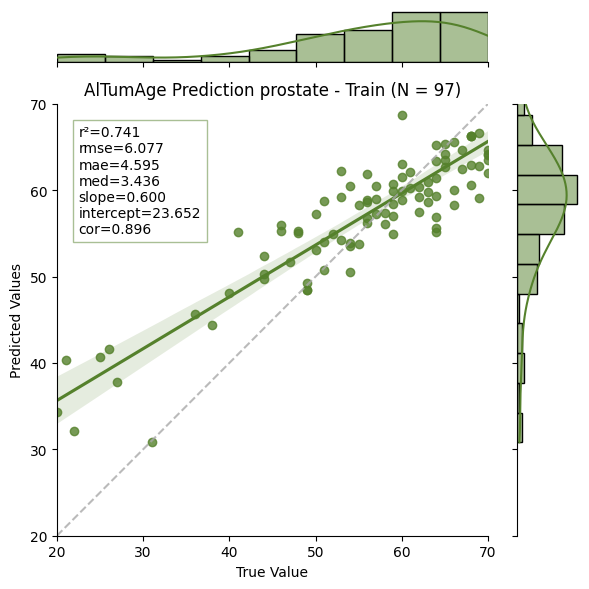

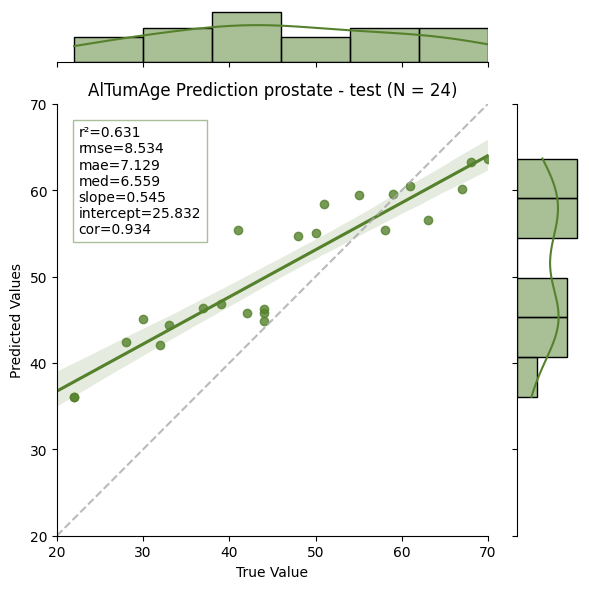

In [12]:
prostate_meth_data = pd.read_csv("../../results/2.epigenetic_clocks/AltumAge/prostate_BQMI_normalized.csv", index_col=0)
prostate_test_data = pd.read_csv("../../metadata/prostate_test_metadata.csv")
prostate_age_data = pd.read_csv("../../metadata/prostate_annotation_meth.csv")

# Reoder 
prostate_meth_data = prostate_meth_data[cpgs]

# Split in train and test
X_train, X_test, y_train, y_test = split_in_train_test(prostate_meth_data, prostate_age_data, prostate_test_data)

### Predict on train 
X_train_scaled = scaler.transform(X_train)
pred_age_train_prostate = AltumAge.predict(X_train_scaled).flatten()

metrics_train_prostate = compute_metrics(y_train, pred_age_train_prostate)
metrics_train_prostate["set"] = "Train"
metrics_train_prostate["tissue"] = "prostate"

plot_model_fit(y_train, 
        pred_age_train_prostate, 
        data_set="Train", 
        title_override = f"AlTumAge Prediction prostate - Train (N = {X_train.shape[0]})", 
        fig_output_path="../../aging_notes/figures/2.epigenetic_clocks/3.AltumAge_prostate_train.pdf")

### Predict on test
X_test_scaled = scaler.transform(X_test)
pred_age_test_prostate = AltumAge.predict(X_test_scaled).flatten()

metrics_test_prostate = compute_metrics(y_test, pred_age_test_prostate)
metrics_test_prostate["set"] = "test"
metrics_test_prostate["tissue"] = "prostate"

plot_model_fit(y_test, 
        pred_age_test_prostate, 
        data_set="test", 
        title_override = f"AlTumAge Prediction prostate - test (N = {X_test.shape[0]})", 
        fig_output_path="../../aging_notes/figures/2.epigenetic_clocks/3.AltumAge_prostate_test.pdf")


train_df = pd.DataFrame({"pred": pred_age_train_prostate, "true": y_train, "sample": X_train.index })
train_df.to_csv("../../results/2.epigenetic_clocks/AltumAge/AltumProstate_train.csv")

test_df = pd.DataFrame({"pred": pred_age_test_prostate, "true": y_test, "sample": X_test.index })
test_df.to_csv("../../results/2.epigenetic_clocks/AltumAge/AltumProstate_test.csv")


In [8]:
## Save results in a tabular format

###Combine data
list_of_dataframes = [metrics_train_lung, metrics_train_colon, metrics_train_ovary, metrics_train_prostate, 
                      metrics_test_lung, metrics_test_colon, metrics_test_ovary, metrics_test_prostate]

metrics_altumAge = pd.concat([pd.DataFrame([m]) for m in list_of_dataframes])

In [9]:
metrics_altumAge.to_csv("../../results/2.epigenetic_clocks/AltumAge/metrics.csv")

In [10]:
metrics_altumAge

,r2,rmse,mae,med,slope,intercept,cor,set,tissue
0,0.747314,5.063326,4.065738,3.281832,0.924946,2.376147,0.894996,Train,Lung
0,0.804143,4.582840,3.533334,2.964394,0.860740,7.391943,0.900305,Train,Colon
0,-0.210655,13.136378,11.507934,11.477837,0.651314,7.541978,0.813001,Train,Ovary
0,0.740925,6.077241,4.595362,3.436188,0.600021,23.651663,0.896346,Train,prostate
0,0.818341,5.487024,4.334149,3.217209,0.883448,4.039636,0.916112,test,Lung
0,0.882481,4.550231,3.374368,2.156836,0.952791,3.216566,0.943820,test,Colon
0,0.367628,10.231677,8.739776,8.112586,0.693351,3.715842,0.880587,test,Ovary
0,0.630706,8.534226,7.129246,6.559177,0.545385,25.831929,0.933823,test,prostate
